## Main task
* Classify images according to cell-type, such as: fibroblast, inflammatory, epithelial or others.
* Using extra_data to improve cell-type prediction

## 1. Setup notebook

In [ ]:
# !pip install tensorflow
# !pip install opencv-python

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/ColabNotebooks/COSC2753/patch_images.zip"

Streaming output truncated to the last 5000 lines.
  inflating: patch_images/5088.png   
  inflating: patch_images/5089.png   
  inflating: patch_images/509.png    
  inflating: patch_images/5090.png   
  inflating: patch_images/5091.png   
  inflating: patch_images/5092.png   
  inflating: patch_images/5093.png   
  inflating: patch_images/5094.png   
  inflating: patch_images/5095.png   
  inflating: patch_images/5096.png   
  inflating: patch_images/5097.png   
  inflating: patch_images/5098.png   
  inflating: patch_images/5099.png   
  inflating: patch_images/51.png     
  inflating: patch_images/510.png    
  inflating: patch_images/5100.png   
  inflating: patch_images/5101.png   
  inflating: patch_images/5102.png   
  inflating: patch_images/5103.png   
  inflating: patch_images/5104.png   
  inflating: patch_images/5105.png   
  inflating: patch_images/5106.png   
  inflating: patch_images/5107.png   
  inflating: patch_images/5108.png   
  inflating: patch_images/5116.png   

In [ ]:
# CHANGE THE DIRECTORY IN YOUR LOCAL MACHINE
PATH = "/content/patch_images"

## 2. Data inspecting

### 2.1. Load main_data csv file

In [ ]:
%cd "/content/drive/MyDrive/ColabNotebooks/COSC2753"

main_data = pd.read_csv('data_labels_mainData.csv')
main_data

/content/drive/.shortcut-targets-by-id/1Awu_oQl1Pf8xoUo_ztxOQfq-cPjn9rjP/COSC2753


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [ ]:
main_data.shape

(9896, 6)

### 2.2. Inspect csv file

From the specifications, the main_data contains both cellType (0 to 3) and isCancerous (0 and 1), while extra_data only contains isCancerous.

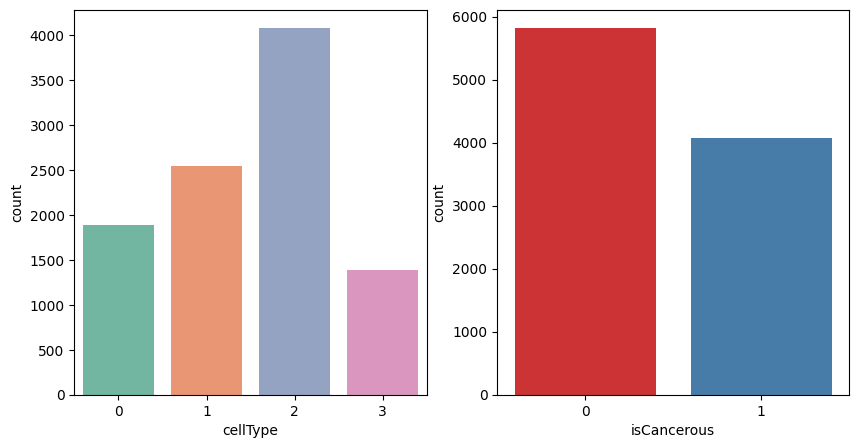

In [ ]:
# plt.style.use('dark_background')

# Countplot the cellType and isCancerous
fig, ax =plt.subplots(1,2, figsize = (10,5))

# 0 = fibroblast, 1 = imflammatory, 2 = epithelial, 3 = others
sns.countplot(main_data['cellType'], palette='Set2', ax=ax[0])

sns.countplot(main_data['isCancerous'], palette='Set1', ax=ax[1])
fig.show()

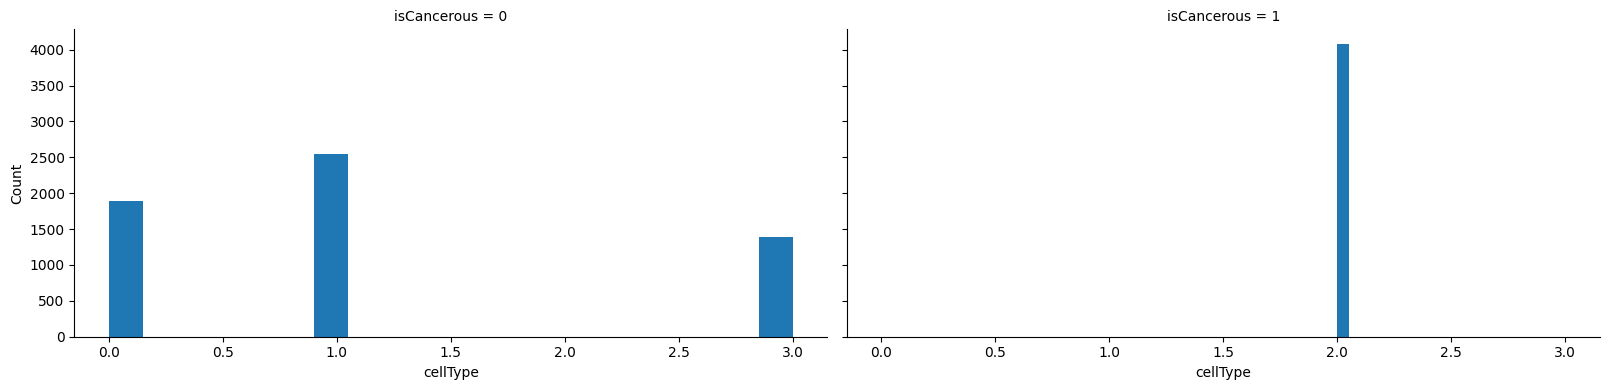

In [ ]:
# Draw the histogram for cellType respected to isCancerous (class 0 and 1)
c = 'cellType'
g = sns.FacetGrid(main_data, col='isCancerous', height=4, aspect=2)
g.map(plt.hist, str(c), bins=20)
g.set_axis_labels(c, "Count")

In [ ]:
# Apply loc to make sure
main_data.loc[(main_data['cellType'] != 2) & (main_data['isCancerous'] == 1)]

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous


From the dataset, it can be said that only cellType = 2 (epithelial) <=> isCancerous = 1

### 2.3. Inspect images

In [ ]:
# Prepare some image of each class
cell0 = main_data['ImageName'].loc[main_data['cellType'] == 0][:4].tolist()
cell1 = main_data['ImageName'].loc[main_data['cellType'] == 1][:4].tolist()
cell2 = main_data['ImageName'].loc[main_data['cellType'] == 2][:4].tolist()
cell3 = main_data['ImageName'].loc[main_data['cellType'] == 3][:4].tolist()

print(cell0)
print(cell1)
print(cell2)
print(cell3)

['22405.png', '22406.png', '22407.png', '22408.png']
['22417.png', '22418.png', '22419.png', '22420.png']
['276.png', '277.png', '278.png', '279.png']
['22423.png', '22424.png', '19061.png', '19062.png']


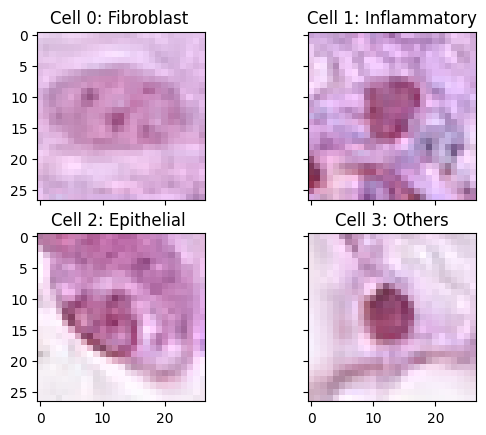

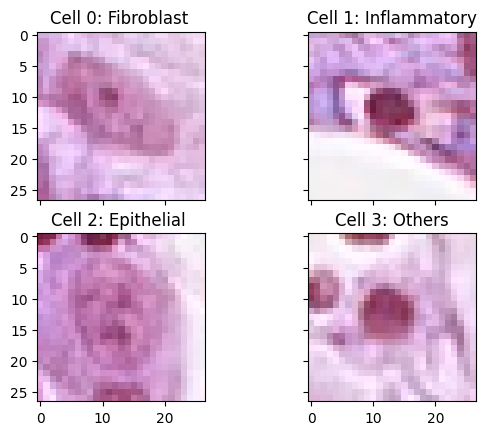

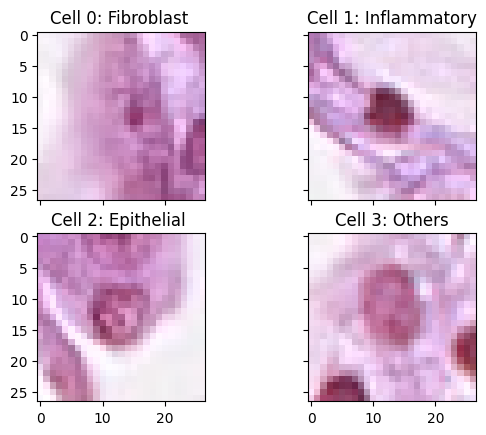

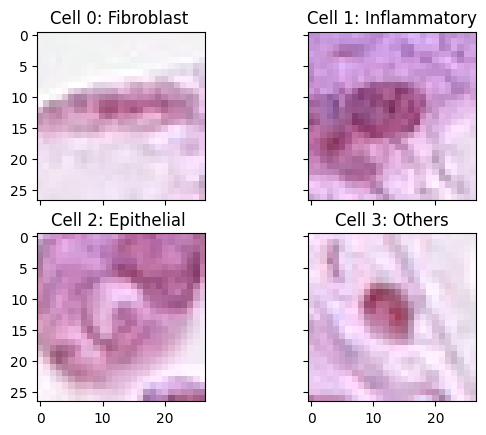

In [ ]:
# Plotting 4 cellType
for i in range (4):
    # Read image
    cell_0 = cv2.imread(os.path.join(PATH, cell0[i]))
    cell_1 = cv2.imread(os.path.join(PATH, cell1[i]))
    cell_2 = cv2.imread(os.path.join(PATH, cell2[i]))
    cell_3 = cv2.imread(os.path.join(PATH, cell3[i]))

    # Create subplots
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)
    
    # Draw cellType 0
    ax0.title.set_text("Cell 0: Fibroblast ")
    ax0.imshow(cell_0)
    
    # Draw cellType 1
    ax1.title.set_text("Cell 1: Inflammatory")
    ax1.imshow(cell_1)
    
    # Draw cellType 2
    ax2.title.set_text("Cell 2: Epithelial ")
    ax2.imshow(cell_2)
    
    # Draw cellType 3
    ax3.title.set_text("Cell 3: Others")
    ax3.imshow(cell_3)

    for ax in fig.get_axes():
        ax.label_outer()

## 3. Data preparation

### 3.1. Split data into train and validation (test) set

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train and validation set
raw_train_df, valid_df = train_test_split(main_data[['ImageName', 'cellType']], test_size=0.3, random_state=9)

print('Train shape:', raw_train_df.shape, 'Validation shape:', valid_df.shape)

Train shape: (6927, 2) Validation shape: (2969, 2)


In [ ]:
raw_train_df

,ImageName,cellType
5740,19796.png,1
8131,3475.png,2
8161,3506.png,2
51,19068.png,3
8717,13791.png,3
...,...,...
6200,10244.png,2
501,4103.png,1
6782,3954.png,0
4444,20286.png,1


In [ ]:
# Sort the label for easier sampling
raw_train_df = raw_train_df.sort_values(by=['cellType']).reset_index(drop = True)
train_X = raw_train_df['ImageName']
train_Y = raw_train_df['cellType']

test_X = valid_df['ImageName']
test_Y = valid_df['cellType']

### 3.2. Create sample image to balance among classes

In [ ]:
from random import randint, choice

def create_train_data(directory, img_list, label):
    # Map the index (0,1,2,3) to its value_counts
    item_order = label.value_counts().index.tolist()
    freq_order = label.value_counts().tolist()

    count_list = [element for _, element in sorted(zip(item_order, freq_order))] # List of value_counts in cellType

    # Create an array contains range for sampling
    sum_range = count_list.copy()
    for i in range(1, len(sum_range)):
        sum_range[i] += sum_range[i - 1]

    sum_range.insert(0, 0)

    # Get the counts from the majourity class
    MAX = max(count_list)

    # Type of interpolation method in OpenCV
    INTERPOLATION = [cv2.INTER_AREA, cv2.INTER_CUBIC, cv2.INTER_LINEAR, cv2.INTER_NEAREST]

    train_data = []

    # Add original data 
    for name in tqdm(img_list, desc="Adding original images"):
        img_path = os.path.join(directory, name)  # Join the path together
        img = cv2.resize(cv2.imread(img_path), (27, 27))  # Transform it into np.array for image
        train_data.append(np.array(img))  # Add to train data

    # Add sample data
    for i in range(4):
        if i != 2: # Class 2 is the majority class
            for j in tqdm(range(MAX - count_list[i]), desc="Sampling class {fc}".format(fc=i)):
                img_path = os.path.join(directory, choice(img_list[sum_range[i]:sum_range[i + 1]]))
                img = cv2.resize(cv2.imread(img_path), (27, 27), interpolation=INTERPOLATION[randint(0, 3)])  # Apply interpolation method
                train_data.append(np.array(img))


    print("\nSuccessfully sample images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

def create_test_data(directory, img_list):
    train_data = []
    for img in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, img)
        img = cv2.resize(cv2.imread(path), (27, 27))
        train_data.append(np.array(img))
    print("\nSuccessfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [ ]:
def create_test_data(directory, img_list):
    test_data = []
    for name in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, name)
        img = cv2.resize(cv2.imread(path), (27, 27))
        test_data.append(np.array(img))
    print("\nSuccessfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(test_data).astype('float32') / 255.0 

### 3.3. Create image array

In [ ]:
train_X_img = create_train_data(PATH, train_X.to_list(), train_Y)
train_X_img.shape

Sampling class : 100%|██████████| 1947/1947 [00:00<00:00, 14267.71it/s]



Successfully sample images!


(11588, 27, 27, 3)

In [ ]:
test_X_img = create_test_data(PATH, test_X.tolist())
test_X_img.shape

Extracting Image Progress: 100%|██████████| 2969/2969 [00:00<00:00, 17015.14it/s]


Successfully import images!


(2969, 27, 27, 3)

In [ ]:
def resampling_label(label): # Map the label to the new sample image
    item_order = label.value_counts().index.tolist()
    freq_order = label.value_counts().tolist()

    label_modify = label.values
    count_list = [element for _, element in sorted(zip(item_order, freq_order))] # List of value_counts in cellType

    MAX = max(count_list)
    for i in range(4):
        label_modify = np.concatenate((label_modify, np.full((MAX - count_list[i],), i, dtype=int)))

    return label_modify


train_Y_mod = resampling_label(train_Y)
train_Y_mod.shape

(11588,)

In [ ]:
test_Y.shape

(2969,)

### 3.4. Data Augmentation

In [ ]:
# Create datagen
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=True)

train_datagen = datagen.flow(train_X_img, train_Y_mod, shuffle=True)

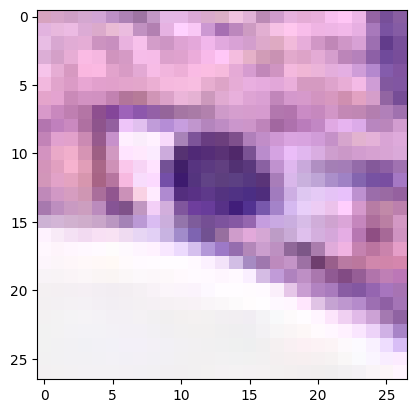

In [ ]:
# Before augmentation (randomly pick an image)
from tensorflow.keras.preprocessing.image import load_img

img = load_img("/content/patch_images/22418.png")
plt.imshow(img)

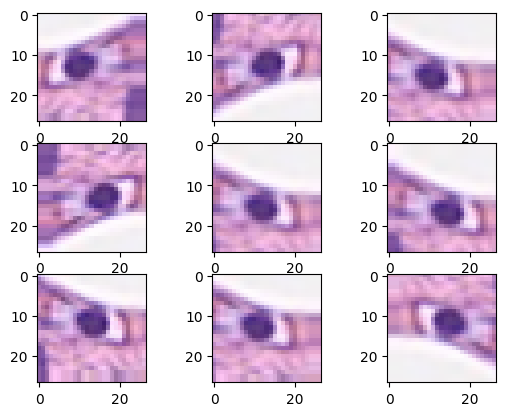

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

# Loading a sample image 
img = load_img("/content/patch_images/22418.png")

# Converting the input sample image to an array
x = img_to_array(img)

# Reshaping the input image
x = x.reshape((1, ) + x.shape) 

# Pass img into datagen
it = datagen.flow(x,batch_size = 1)

# Plot some samples
for i in range(9):
    # Define subplot
    plt.subplot(330 + 1 + i)
    # Generate batch of images
    batch = it.next()
    # Convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # Plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

## 4. Developing model and training

### 4.1. Constructing CNN network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential()  # Initiate the model

# First convolutional layer(s)
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', input_shape=(27, 27, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Second convolutional layer(s)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Third convolutional layer(s)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Fully connected layer(s)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(l=0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) # Output is 0 to 3

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_48 (Batc (None, 27, 27, 32)        128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
batch_normalization_49 (Batc (None, 27, 27, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 13, 13, 64)       

### 4.2. Compile and training

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.0005)

model.compile(optimizer=opt , loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(monitor='accuracy', min_delta=0.001, patience=10, verbose=1, mode='auto')
 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15) 

EPOCHS = 500
BATCH_SIZE = 32

import time
start_time = time.time()

history = model.fit(train_datagen, 
                    validation_data=(test_X_img, test_Y), 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=1,
                    callbacks=[reduce_lr, early])

print("---  Training time in seconds ---%s " % (time.time() - start_time))

Epoch 1/500
363/363 [==============================] - 7s 17ms/step - loss: 26.2110 - accuracy: 0.4750 - val_loss: 17.8375 - val_accuracy: 0.4998
Epoch 2/500
363/363 [==============================] - 6s 16ms/step - loss: 15.1993 - accuracy: 0.5831 - val_loss: 10.1354 - val_accuracy: 0.6487
Epoch 3/500
363/363 [==============================] - 6s 16ms/step - loss: 8.8264 - accuracy: 0.6278 - val_loss: 6.1012 - val_accuracy: 0.6049
Epoch 4/500
363/363 [==============================] - 6s 16ms/step - loss: 5.2356 - accuracy: 0.6458 - val_loss: 3.7843 - val_accuracy: 0.6332
Epoch 5/500
363/363 [==============================] - 6s 16ms/step - loss: 3.3138 - accuracy: 0.6504 - val_loss: 2.5866 - val_accuracy: 0.6622
Epoch 6/500
363/363 [==============================] - 6s 16ms/step - loss: 2.2273 - accuracy: 0.6839 - val_loss: 1.7159 - val_accuracy: 0.7107
Epoch 7/500
363/363 [==============================] - 6s 16ms/step - loss: 1.6186 - accuracy: 0.6849 - val_loss: 1.3363 - val_accur

### 4.3. Save model

In [ ]:
from datetime import datetime
dt_string = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
export = 'Task2_{ft}.h5'.format(ft=dt_string)
print(export)

model.save(export)

Task2_24-05-2021_05-46-46.h5


The best model is save with the name: Task2_Main.h5

### 4.4. Plot training history

93/93 [==============================] - 0s 3ms/step - loss: 0.5143 - accuracy: 0.8427
Validation loss: 0.5142750144004822
Validation accuracy: 0.8427079916000366
Max Validation accuracy: 0.8514651656150818


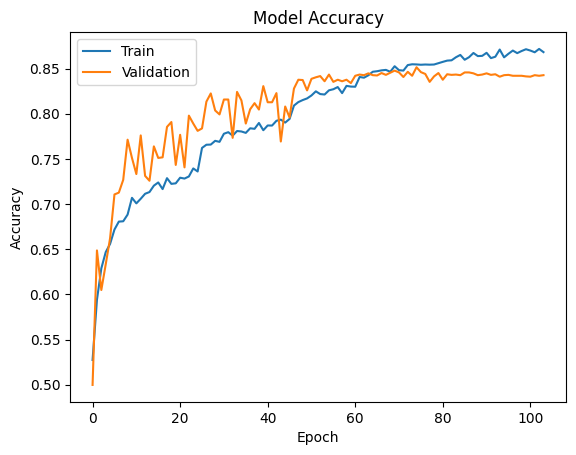

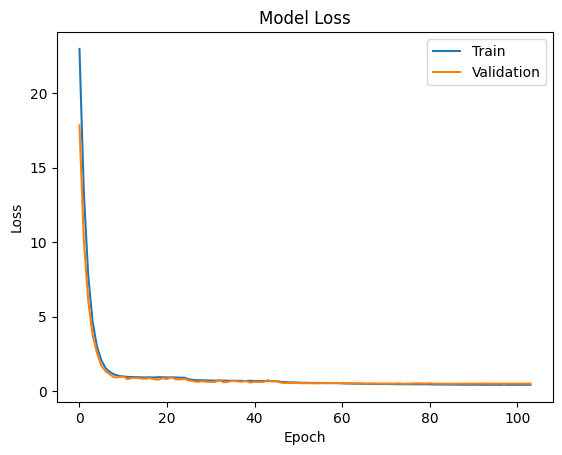

In [ ]:
plt.style.use('default')

scores = model.evaluate(test_X_img, test_Y, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])
print('Max Validation accuracy:', max(history.history['val_accuracy']))
# # visualizing losses and accuracy
# print(history.history.keys())
# # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### 4.5. Load the best model for classification report

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

best = load_model('Task2_Main.h5')

predictions = best.predict_classes(test_X_img)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(test_Y, predictions, target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']))

              precision    recall  f1-score   support

     Class 0       0.80      0.81      0.81       586
     Class 1       0.80      0.84      0.82       765
     Class 2       0.95      0.91      0.93      1182
     Class 3       0.70      0.71      0.70       436

    accuracy                           0.84      2969
   macro avg       0.81      0.82      0.82      2969
weighted avg       0.85      0.84      0.84      2969



## 5. Utilizing extra_data

We will try to use our model to predict the celltype in extraData, then carefully select the data to enlarge our train dataset again

### 5.1 Classify the cellType in extraData

In [ ]:
extra_data = pd.read_csv('data_labels_extraData.csv')
extra_data

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0
...,...,...,...,...
10379,20028,99,20028.png,0
10380,20029,99,20029.png,0
10381,20030,99,20030.png,0
10382,20031,99,20031.png,0


In [ ]:
test_img = create_test_data(PATH, extra_data['ImageName'].to_list())
test_img.shape

Extracting Image Progress: 100%|██████████| 10384/10384 [00:00<00:00, 16343.01it/s]


Successfully import images!


(10384, 27, 27, 3)

In [ ]:
main_model = load_model('Task2_Main.h5')

result = main_model.predict_classes(test_img)
result = result.reshape(1,-1)[0]
result

array([0, 0, 0, ..., 3, 2, 3])

In [ ]:
extra_data['cellType'] = pd.Series(result)
extra_data

,InstanceID,patientID,ImageName,isCancerous,cellType
0,12681,61,12681.png,0,0
1,12682,61,12682.png,0,0
2,12683,61,12683.png,0,0
3,12684,61,12684.png,0,0
4,12685,61,12685.png,0,0
...,...,...,...,...,...
10379,20028,99,20028.png,0,3
10380,20029,99,20029.png,0,0
10381,20030,99,20030.png,0,3
10382,20031,99,20031.png,0,2


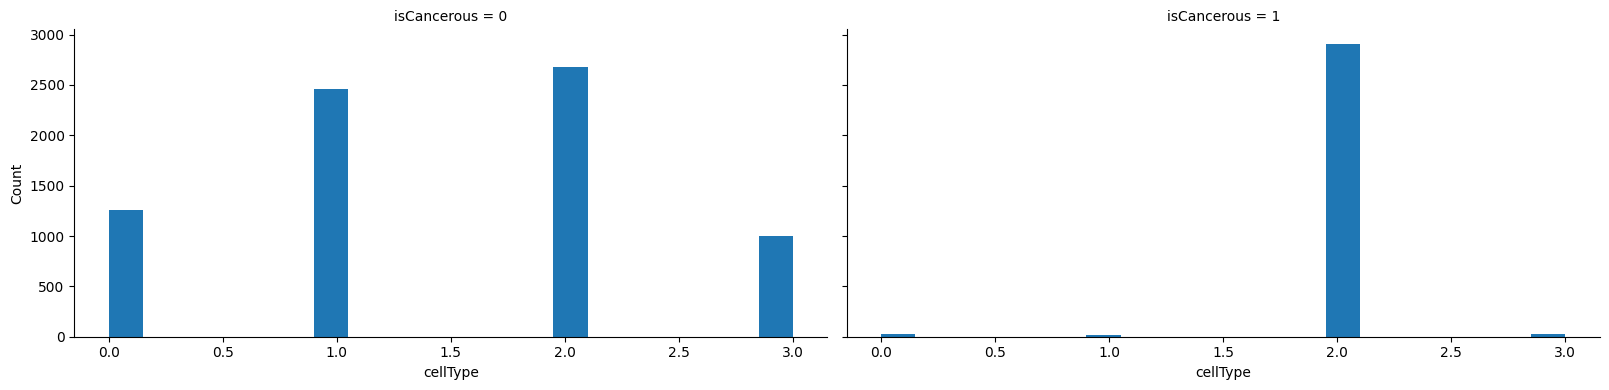

In [ ]:
# Draw the histogram for cellType respected to isCancerous (class 0 and 1)
c = 'cellType'
g = sns.FacetGrid(extra_data, col='isCancerous', height=4, aspect=2)
g.map(plt.hist, str(c), bins=20)
g.set_axis_labels(c, "Count")

From our assumption, we can have 4 choices to add more data:
* Class 2 with isCancerous = 1
* Other class (0,1,3) with isCancerous = 0
* All true positives (2 of above)
* Directly assigned isCancerous = 1 => cellType = 2

We will pick the true positives then fit again into our model to see whether there ar any improvement

### 5.2. Merge the extract extraData into mainData

In [ ]:
TP_other_class = extra_data.loc[((extra_data['isCancerous'] == 0) & (extra_data['cellType'] != 2))]
# TP_class_2 = extra_data.loc[(extra_data['isCancerous'] == 1) & (extra_data['cellType'] == 2)]
# TP_class_2
# # TP_other_class

# frames = [TP_other_class, TP_class_2]
# extra_train = pd.concat(frames)
# extra_train

In [ ]:
raw_train_df

,ImageName,cellType
0,8644.png,0
1,1527.png,0
2,3001.png,0
3,7773.png,0
4,18420.png,0
...,...,...
6922,13277.png,3
6923,7897.png,3
6924,17755.png,3
6925,15707.png,3


In [ ]:
tmp = [raw_train_df, TP_other_class[['ImageName','cellType']]]
train_final = pd.concat(tmp)
train_final

,ImageName,cellType
0,8644.png,0
1,1527.png,0
2,3001.png,0
3,7773.png,0
4,18420.png,0
...,...,...
10377,20026.png,0
10379,20028.png,3
10380,20029.png,0
10381,20030.png,3


### 5.3. Split into image list and label

In [ ]:
train_final = train_final.sort_values(by=['cellType']).reset_index(drop = True)
train_X_new = train_final['ImageName']
train_Y_new = train_final['cellType']

In [ ]:
train_Y_new.value_counts()

1    4238
2    2897
0    2562
3    1947
Name: cellType, dtype: int64

In [ ]:
train_X_img_new = create_train_data(PATH, train_X_new.to_list(), train_Y_new)
train_X_img_new.shape

Sampling class 3: 100%|██████████| 2291/2291 [00:00<00:00, 14820.50it/s]



Successfully sample images!


(16952, 27, 27, 3)

In [ ]:
train_Y_mod_new = resampling_label(train_Y_new)
train_Y_mod_new.shape

(16952,)

In [ ]:
new_datagen = datagen.flow(train_X_img_new, train_Y_mod_new, shuffle=True)

### 5.4. Compile and evaluating

In [ ]:
start_time = time.time()

history_new = model.fit(new_datagen, 
                    validation_data=(test_X_img, test_Y), 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=1,
                    callbacks=[reduce_lr, early])

print("---  Training time in seconds ---%s " % (time.time() - start_time))

Epoch 1/500
530/530 [==============================] - 11s 17ms/step - loss: 24.5832 - accuracy: 0.4903 - val_loss: 13.4000 - val_accuracy: 0.5951
Epoch 2/500
530/530 [==============================] - 8s 16ms/step - loss: 11.0123 - accuracy: 0.6178 - val_loss: 6.3097 - val_accuracy: 0.5490
Epoch 3/500
530/530 [==============================] - 9s 16ms/step - loss: 5.0335 - accuracy: 0.6470 - val_loss: 2.9851 - val_accuracy: 0.6730
Epoch 4/500
530/530 [==============================] - 8s 16ms/step - loss: 2.5314 - accuracy: 0.6711 - val_loss: 1.8956 - val_accuracy: 0.6511
Epoch 5/500
530/530 [==============================] - 8s 16ms/step - loss: 1.5561 - accuracy: 0.6780 - val_loss: 1.1753 - val_accuracy: 0.7289
Epoch 6/500
530/530 [==============================] - 9s 16ms/step - loss: 1.1826 - accuracy: 0.6869 - val_loss: 1.0899 - val_accuracy: 0.6804
Epoch 7/500
530/530 [==============================] - 9s 16ms/step - loss: 1.0492 - accuracy: 0.6926 - val_loss: 0.9326 - val_accur

93/93 [==============================] - 0s 3ms/step - loss: 0.5122 - accuracy: 0.8400
Validation loss: 0.5121530890464783
Validation accuracy: 0.8400134444236755
Max Validation accuracy: 0.8450656533241272


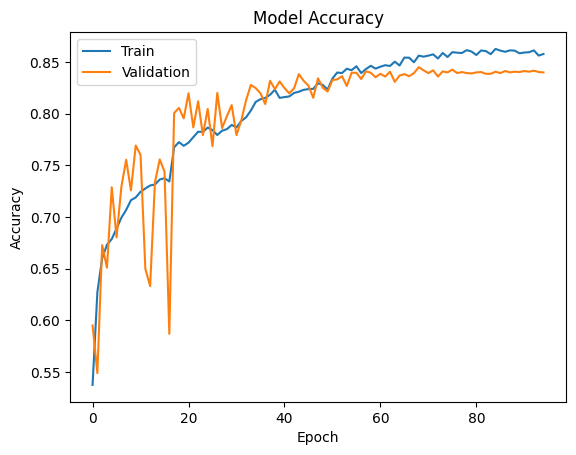

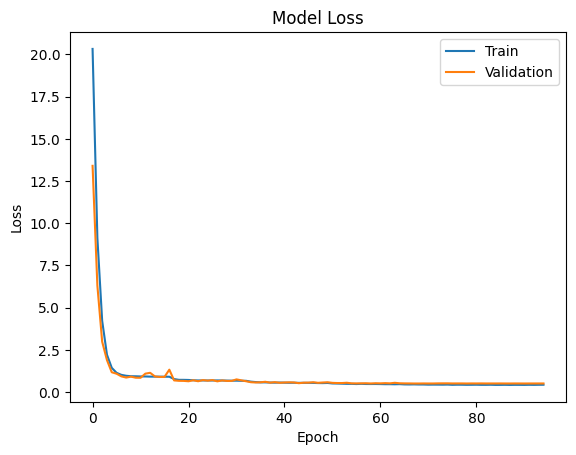

In [ ]:
plt.style.use('default')

scores = model.evaluate(test_X_img, test_Y, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])
print('Max Validation accuracy:', max(history_new.history['val_accuracy']))
# # visualizing losses and accuracy
# print(history.history.keys())
# # summarize history for accuracy
plt.plot(history_new.history['accuracy'])
plt.plot(history_new.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_new.history['loss'])
plt.plot(history_new.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()